In [106]:
%load_ext autoreload
%autoreload 2

# Import own packages
# sys.path.append("/mnt/d/Projects/Navigation/MyCode/sydr")
import sys
sys.path.append("/mnt/c/Users/vmangr/Documents/Code/sydr")
from sydr.utils.constants import GPS_L1CA_CODE_FREQ 

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from plot import plotCorrelation, plotSignals
from misc import *
from axcoperations import loadd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create a GNSS signal

In [86]:
# Parameters
prn = 1
samplingFrequency = 5e6
cn0_target = 45
signal_bw = GPS_L1CA_CODE_FREQ # Bandwidth of the signal for CN0 to SNR computation
#quantization_bits = 8

# Generate signals
signal = generateGPSL1CA(prn=prn, samplingFrequency=samplingFrequency)
sigma_noise = getSigmaFromCN0(signal_power_dB=0, cn0_target_dB=cn0_target, signal_bw=signal_bw)
signal_noisy = addWhiteNoise(signal, sigma=sigma_noise)

# Quantization 
signal_quantized = quantize(signal_noisy, 8)


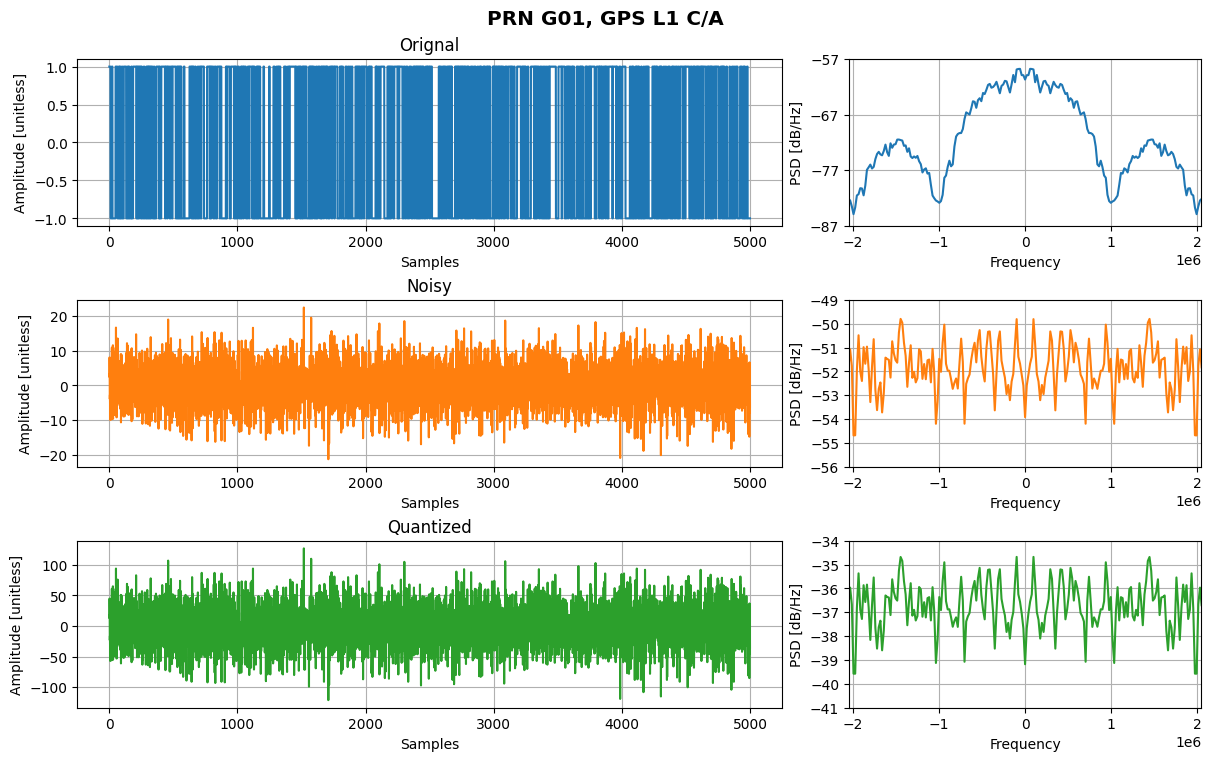

In [87]:
plotSignals({'Orignal' : signal, 'Noisy': signal_noisy, 'Quantized': signal_quantized}, 
            samplingFrequency, GPS_L1CA_CODE_FREQ, f"PRN G{prn:02d}, GPS L1 C/A")

(array([   8.,   82.,  291.,  916., 1369., 1356.,  713.,  224.,   35.,
           6.]),
 array([-121. ,  -96.2,  -71.4,  -46.6,  -21.8,    3. ,   27.8,   52.6,
          77.4,  102.2,  127. ]),
 <BarContainer object of 10 artists>)

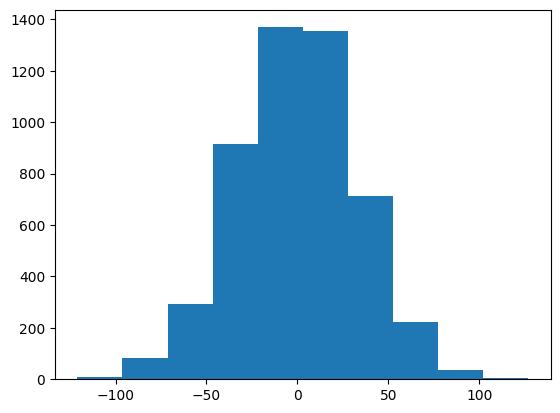

In [111]:
plt.hist(signal_quantized)

### Perform correlation

In [88]:
# Correlate
signal_corr, signal_lags = correlate(signal, signal)
signal_noisy_corr, signal_noisy_lags = correlate(signal, signal_noisy)

In [89]:
signal_quantized_corr, signal_quantized_lags = correlate(signal, signal_quantized)

In [109]:
import evoapproxlib as eal
from axcoperations import correlation
signal_axc_corr, signal_axc_lags = correlation(signal, signal_quantized, axc_mult=eal.mul8s_1KR3.calc)

In [103]:
signal_axc_corr - signal_quantized_corr

array([-1., -1., -4., ..., -9., -6., -3.])

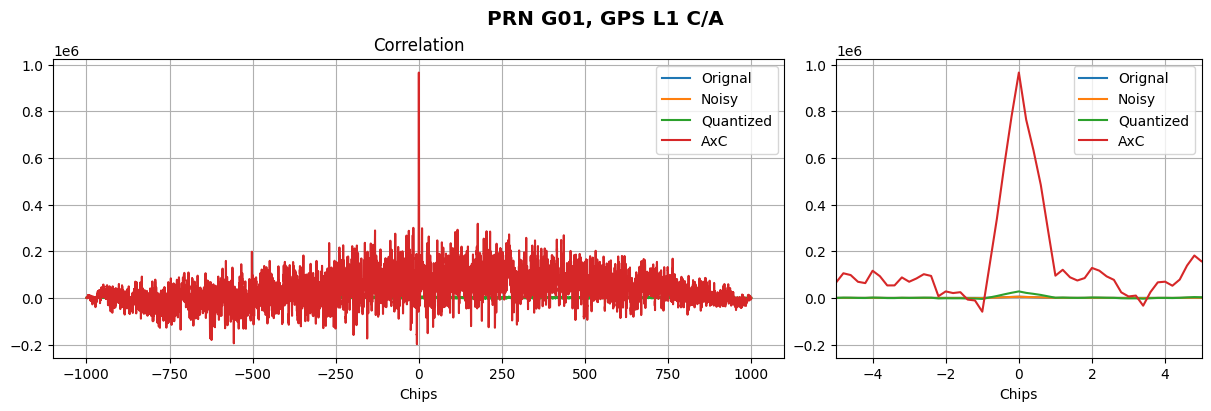

In [110]:
plotCorrelation({
'Orignal' : (signal_corr, signal_lags), 
'Noisy': (signal_noisy_corr, signal_noisy_lags), 
'Quantized': (signal_quantized_corr, signal_quantized_lags),
'AxC': (signal_axc_corr, signal_axc_lags)}, 
samplingFrequency, GPS_L1CA_CODE_FREQ, f"PRN G{prn:02d}, GPS L1 C/A")

In [92]:
import numpy as np

class CustomTypeArray(np.ndarray):
    def __new__(cls, input_array):
        obj = np.asarray(input_array).view(cls)
        return obj

    # Define custom __add__ method with custom addition logic and printing
    def __add__(self, other):
        # Check data type compatibility (optional)
        if not isinstance(other, (CustomTypeArray, np.ndarray, np.number)):
            raise TypeError("Unsupported operand type(s) for +: 'CustomTypeArray' and '{}'".format(type(other)))

        # Custom addition logic and printing
        if isinstance(other, (CustomTypeArray, np.ndarray)):
            if self.shape != other.shape:
                raise ValueError("Shapes of operands must match")
            result = np.empty_like(self)  # Create empty array for result
            for i in range(len(self)):
                print(f"Adding elements at index {i}: {self[i]} + {other[i]}")
                result[i] = self[i] + other[i]  # Perform custom addition
            return CustomTypeArray(result)
        else:
            # Handle addition with a number (optional custom logic here)
            raise NotImplementedError("Addition with non-array operand not implemented")

# Example usage:
arr1 = CustomTypeArray([1, 2, 3])
arr2 = CustomTypeArray([4, 5, 6])

try:
  arr3 = arr1 + arr2  # Custom addition with printing
except NotImplementedError as e:
  print(e)

Adding elements at index 0: 1 + 4
Adding elements at index 1: 2 + 5
Adding elements at index 2: 3 + 6


In [93]:
import numpy as np
from matplotlib.ticker import MultipleLocator
from axcoperations import lcadd
import evoapproxlib as eal

axc_bits = 1 # Lower bits approximated
bits = 8
max_value = 2**bits // 2
i_range = np.arange(-max_value, max_value, dtype=np.int16)
j_range = np.arange(-max_value, max_value, dtype=np.int16)
exact_results = np.zeros((2**bits, 2**bits))
axc_results = np.zeros((2**bits, 2**bits))
for i in i_range:
    for j in j_range:
        #axc_results[i+max_value,j+max_value] = lcadd(i, j, axc_bits)
        axc_results[i+max_value,j+max_value] = eal.mul8s_1KVA.calc(i, j)
        exact_results[i+max_value,j+max_value] = i * j

error = exact_results - axc_results
minError = np.min(error)
maxError = np.max(error)

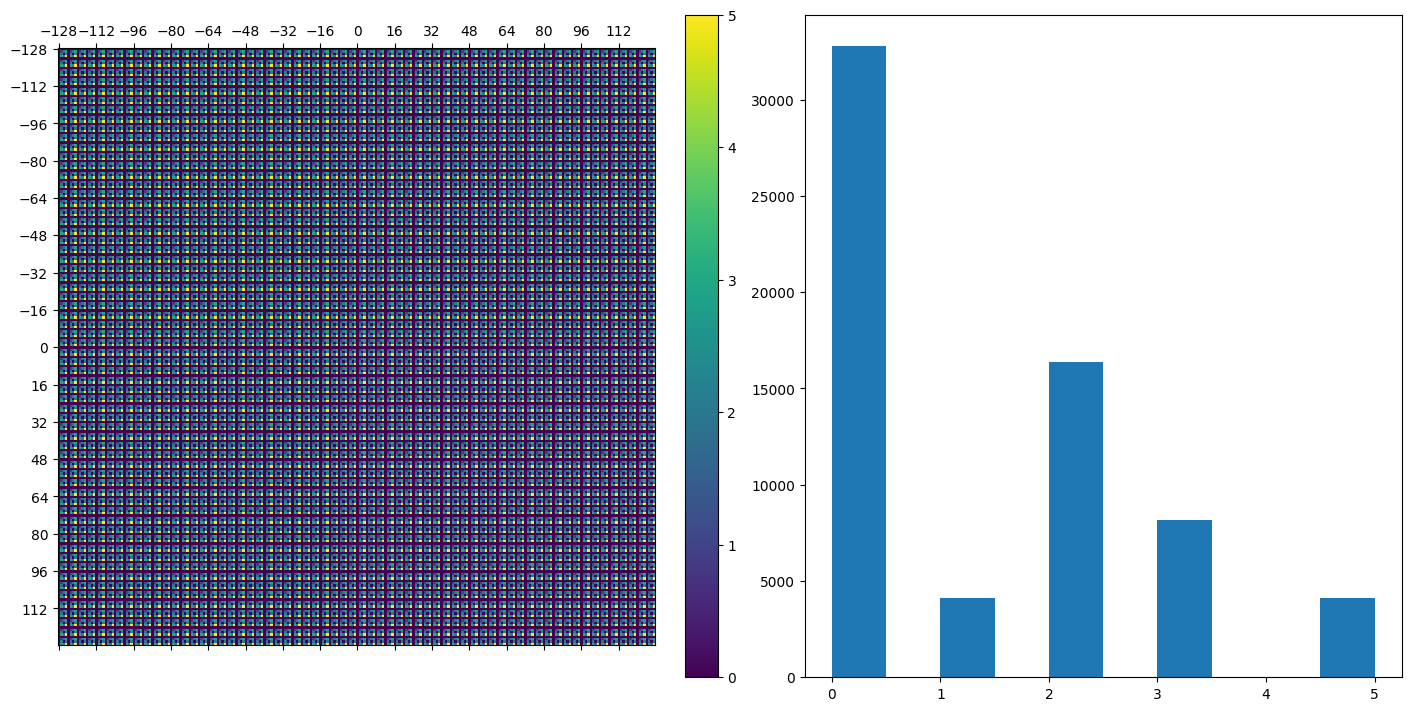

In [94]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), layout="constrained")
plot = axs[0].matshow(error, extent=(-max_value-0.5, max_value-0.5, max_value-0.5, -max_value-0.5))
axs[0].xaxis.set_major_locator(MultipleLocator(max_value/8))
axs[0].yaxis.set_major_locator(MultipleLocator(max_value/8))
cbar = fig.colorbar(plot, ax=axs[0])

axs[1] = plt.hist(error.flatten())

In [95]:
import evoapproxlib as eal
import pandas as pd 
import matplotlib.pyplot as plt

kpis = ["MAE_PERCENT", "MAE", "WCE_PERCENT", "WCE", "WCRE_PERCENT", "EP_PERCENT", 
        "MRE_PERCENT", "MSE", "PDK45_PWR", "PDK45_AREA", "PDK45_DELAY"]

module_list = []
for name, module in eal.multipliers['16x16_signed'].items():
    mdict = {"NAME": name}
    for k in kpis:
        mdict[k] = getattr(module, k)
    module_list.append(mdict)
    #print(f"{name} | {module.MAE:>6} | {module.WCE:>6} | {module.MSE:>9} | {module.PDK45_PWR:>9}")

df = pd.DataFrame(module_list) 


In [96]:
df = df.sort_values(by=['MAE'], ascending=False)
df

,NAME,MAE_PERCENT,MAE,WCE_PERCENT,WCE,WCRE_PERCENT,EP_PERCENT,MRE_PERCENT,MSE,PDK45_PWR,PDK45_AREA,PDK45_DELAY
3,mul16s_GAT,0.01200,516096.0,0.04800,2064384.0,6300.0,98.44,1.060,4.772782e+11,1.396,1932.6,2.57
6,mul16s_HFZ,0.00200,87012.0,0.01100,458703.0,6300.0,98.43,0.220,1.252699e+10,1.483,1935.9,2.55
0,mul16s_G7F,0.00130,57344.0,0.00530,229376.0,700.0,87.50,0.120,6.263494e+09,1.961,2495.7,2.87
8,mul16s_HHP,0.00089,38343.0,0.00460,196599.0,1500.0,93.75,0.098,2.505398e+09,1.775,2031.1,2.67
7,mul16s_GK2,0.00057,24580.0,0.00230,98369.0,6500.0,92.19,0.052,1.252699e+09,2.124,2640.3,2.95
4,mul16s_HDG,0.00032,13653.0,0.00150,65535.0,300.0,75.00,0.034,3.579139e+08,2.130,2576.5,2.98
2,mul16s_G80,0.00019,8192.0,0.00076,32768.0,100.0,50.00,0.018,1.789570e+08,2.326,2764.2,3.09
1,mul16s_G7Z,0.00019,8192.0,0.00076,32769.0,300.0,62.50,0.018,1.789570e+08,2.325,2760.4,3.11
5,mul16s_HEB,0.00000,0.0,0.00000,0.0,0.0,0.00,0.000,0.000000e+00,2.400,2614.0,3.05


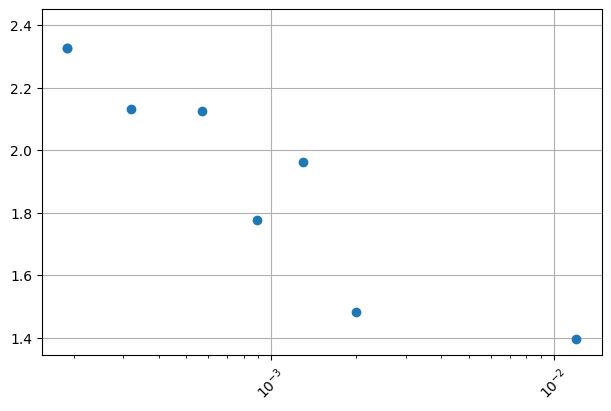

In [97]:
fig, ax = plt.subplots(figsize=(6, 4), layout="constrained")
plt.scatter(df['MAE_PERCENT'], df['PDK45_PWR'])
_ = plt.xticks(rotation=45)
plt.grid()
ax.set_axisbelow(True)
ax.set_xscale('log')

In [98]:
df['NAME'].to_list()

['mul16s_GAT',
 'mul16s_HFZ',
 'mul16s_G7F',
 'mul16s_HHP',
 'mul16s_GK2',
 'mul16s_HDG',
 'mul16s_G80',
 'mul16s_G7Z',
 'mul16s_HEB']

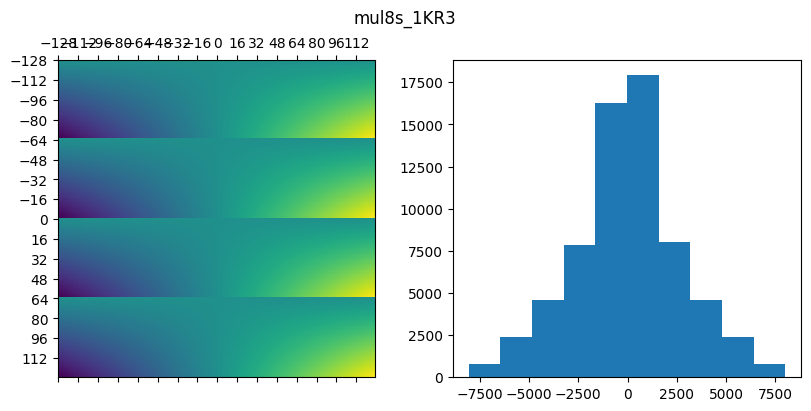

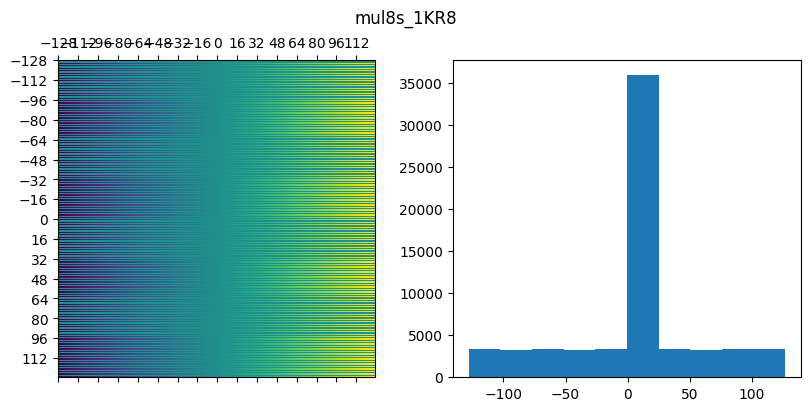

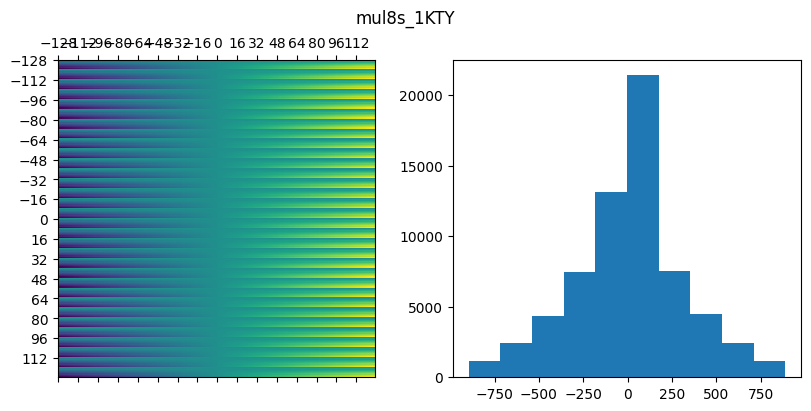

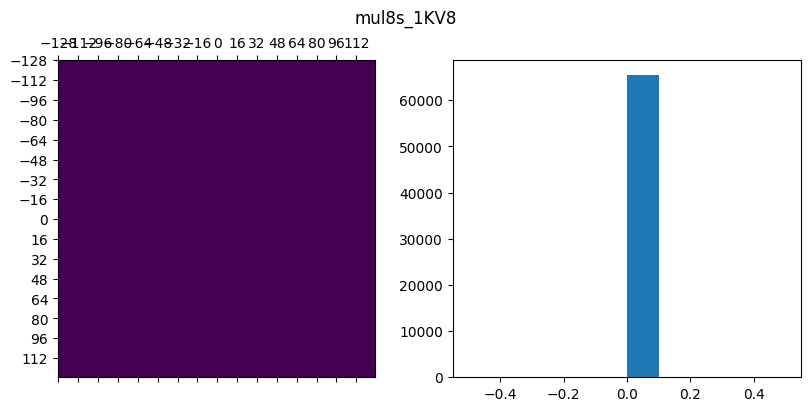

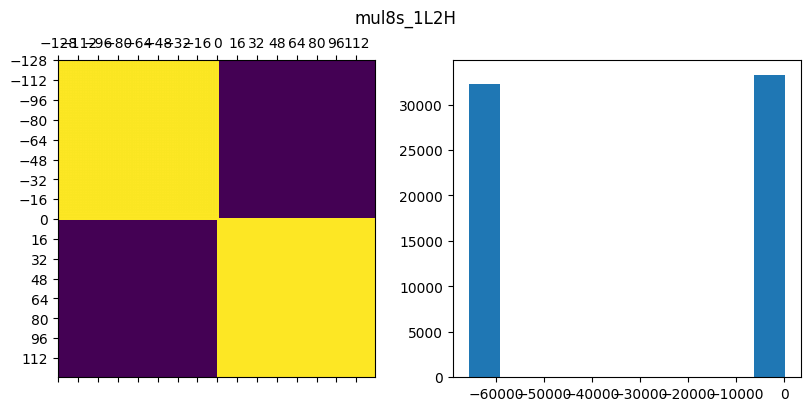

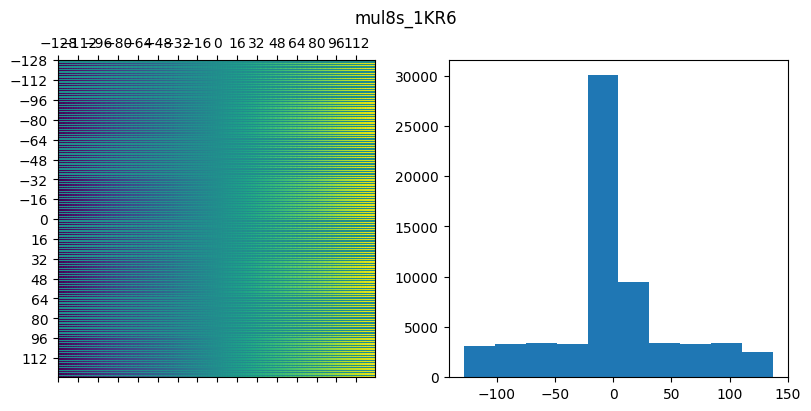

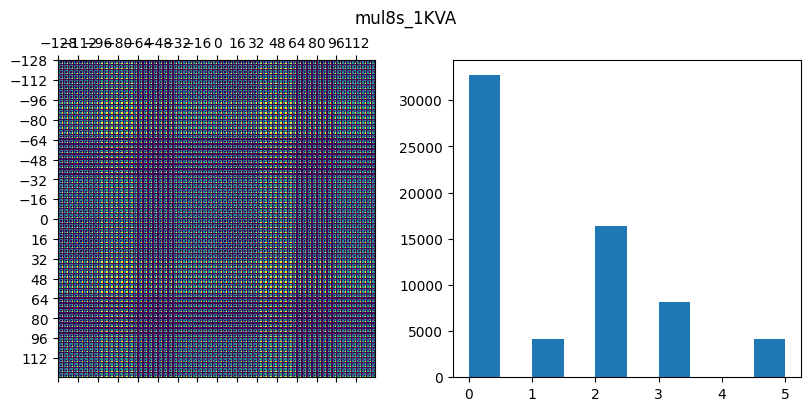

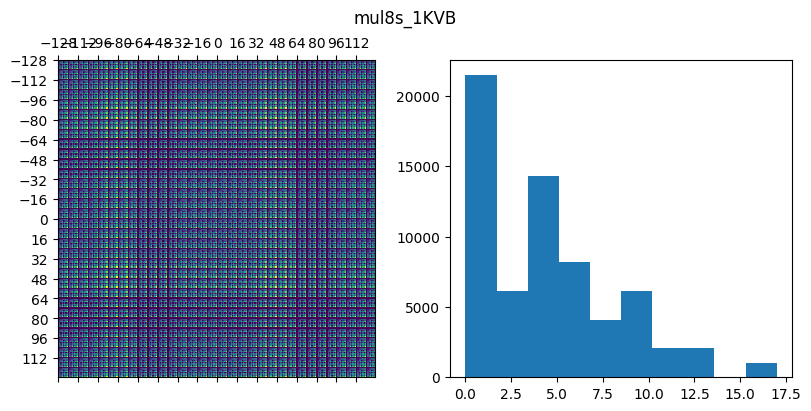

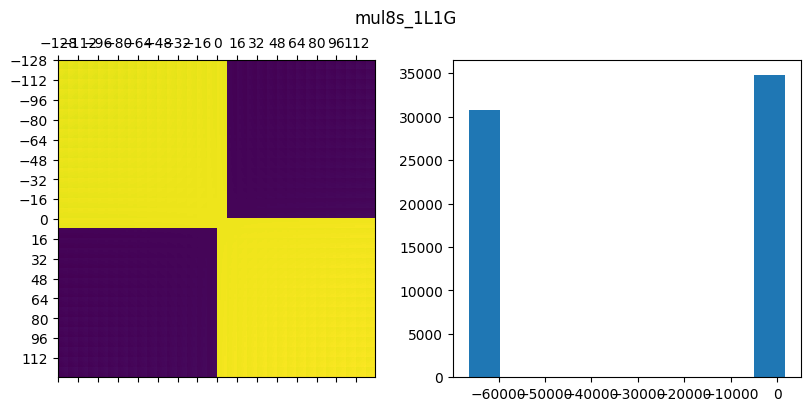

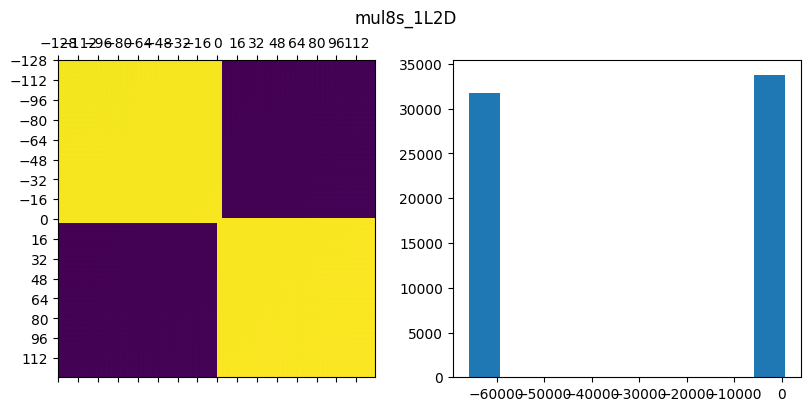

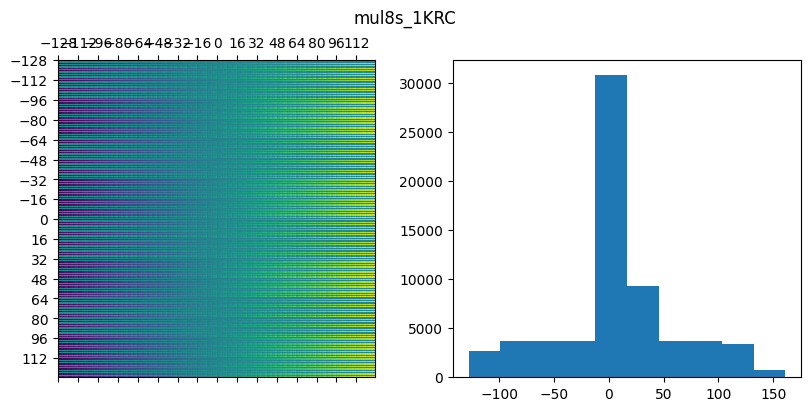

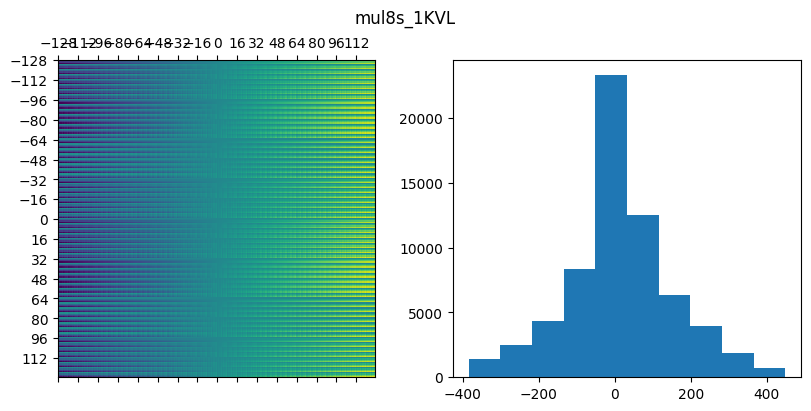

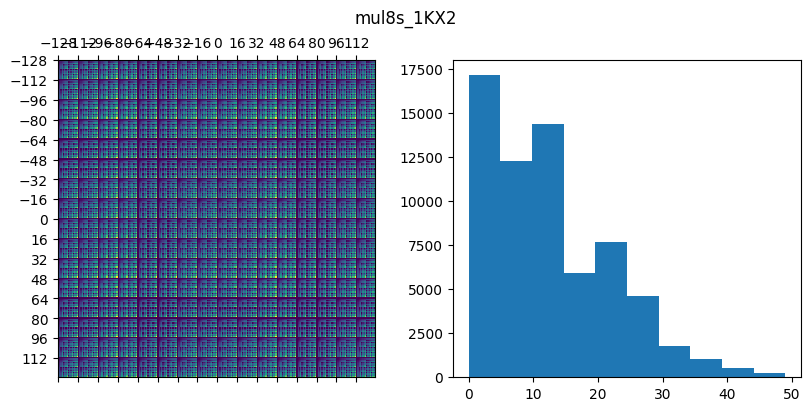

In [108]:
import numpy as np
from matplotlib.ticker import MultipleLocator
from axcoperations import lcadd
import evoapproxlib as eal

axc_bits = 1 # Lower bits approximated
bits = 8
max_value = 2**bits // 2
i_range = np.arange(-max_value, max_value, dtype=np.int16)
j_range = np.arange(-max_value, max_value, dtype=np.int16)
exact_results = np.zeros((2**bits, 2**bits))
axc_results = np.zeros((2**bits, 2**bits))

for name, module in eal.multipliers['8x8_signed'].items():
    for i in i_range:
        for j in j_range:
            axc_mult = getattr(module, 'calc')
            #axc_results[i+max_value,j+max_value] = lcadd(i, j, axc_bits)
            axc_results[i+max_value,j+max_value] = axc_mult(i, j)
            exact_results[i+max_value,j+max_value] = i * j
            
    error = exact_results - axc_results
    minError = np.min(error)
    maxError = np.max(error)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
    fig.suptitle(f"{name}")
    plot = axs[0].matshow(error, extent=(-max_value-0.5, max_value-0.5, max_value-0.5, -max_value-0.5))
    axs[0].xaxis.set_major_locator(MultipleLocator(max_value/8))
    axs[0].yaxis.set_major_locator(MultipleLocator(max_value/8))
    axs[1] = plt.hist(error.flatten())